In [11]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy import stats
import shap
import seaborn as sns

def calculate_correlations(shap_values, features_df, feature_names, num_classes):
    correlation_df = pd.DataFrame()

    for feature in feature_names:
        correlation_dict = {'feature': feature}

        for i in range(num_classes):
            shap_values_i = shap_values[i][:, features_df.columns.get_loc(feature)]
            feature_values_i = features_df[feature].values

            correlation_coefficient_i = np.corrcoef(shap_values_i, feature_values_i)[0, 1]
            correlation_dict[f'correlation_{i}'] = correlation_coefficient_i

        correlation_df = correlation_df.append(correlation_dict, ignore_index=True)

    return correlation_df

def XGBoost(X, y):
    # データを訓練用とテスト用に分割
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # 訓練データをさらに訓練用と検証用に分割
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)

    """
    # モデルのパラメータを設定(CPU)
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': 0.1,
        'max_depth': 4,
        'seed': 0
    }"""
    
    # モデルのパラメータを設定(GPU)
    params = {
        'objective': 'multi:softmax',
        'eval_metric': 'mlogloss',
        'num_class' : 4,
        'eta': 0.1,
        'max_depth': 12,
        'seed': 0,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor'
    }

    # データをpandas.DataFrame形式で保存
    X_train_df = pd.DataFrame(X_train, columns=column_names)
    y_train_df = pd.DataFrame(y_train, columns=column_names)

    # 訓練データと検証データをXGBoostのDMatrix形式に変換
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # 訓練データと検証データのセットをリストに格納
    evals = [(dtrain, 'train'), (dval, 'eval')]

    # モデルを訓練
    bst = xgb.train(params, dtrain, num_boost_round=10000, evals=evals, early_stopping_rounds=100)

    # テストデータをDMatrix形式に変換
    dtest = xgb.DMatrix(X_test)

    # 訓練データで予測
    y_train_pred = bst.predict(dtrain)

    # テストデータで予測
    y_pred = bst.predict(dtest)

    # 評価
    train_accuracy = accuracy_score(y_train, y_train_pred.round())
    print(f"Training Accuracy: {train_accuracy*100:.2f}%")

    # 評価
    test_accuracy = accuracy_score(y_test, y_pred.round())
    print(f"Test Accuracy: {test_accuracy*100:.2f}%")
    
    return X_train_df, y_train_df, bst

def normalize_per_state(df, start, end):
    scaler = StandardScaler()
    df.iloc[start:end, :] = scaler.fit_transform(df.iloc[start:end, :])
    return df


In [2]:
raw = 0 #rawデータならば１、Bandなら０,

# 1秒ごとのデータに分割
n_samples_per_second = 256  # 256Hzのサンプリングレート
total_seconds = 10  # 全体の秒数

# データの読み込み
if(raw):
    df = pd.read_csv('Raw.csv')
    #df = pd.read_csv('Raw_ICA.csv')
else:
    #df = pd.read_csv('Band.csv')
    df = pd.read_csv('emotion.csv')


# チャンネルごとに正規化
#scaler = StandardScaler()
#for column in df.columns[:-1]:  # 'State'列を除くすべての列
#    df[column] = scaler.fit_transform(df[column].values.reshape(-1, 1))


In [3]:
# Hzごと
# 特徴量と目標変数を抽出する
X = df.drop('State', axis=1)  # 'State'以外の列すべてを特徴量とします
y = df['State']  # 'State'を目標変数とします

# 列名のリストを定義
column_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
#XGBoost
X_train_df, y_train_df, bst = XGBoost(X, y)

[0]	train-mlogloss:1.36388	eval-mlogloss:1.36588
[1]	train-mlogloss:1.34416	eval-mlogloss:1.34804
[2]	train-mlogloss:1.32597	eval-mlogloss:1.33180
[3]	train-mlogloss:1.31019	eval-mlogloss:1.31771
[4]	train-mlogloss:1.29542	eval-mlogloss:1.30468
[5]	train-mlogloss:1.28153	eval-mlogloss:1.29266
[6]	train-mlogloss:1.26865	eval-mlogloss:1.28161
[7]	train-mlogloss:1.25693	eval-mlogloss:1.27163
[8]	train-mlogloss:1.24597	eval-mlogloss:1.26243
[9]	train-mlogloss:1.23621	eval-mlogloss:1.25424
[10]	train-mlogloss:1.22742	eval-mlogloss:1.24688
[11]	train-mlogloss:1.21807	eval-mlogloss:1.23931
[12]	train-mlogloss:1.20916	eval-mlogloss:1.23222
[13]	train-mlogloss:1.20112	eval-mlogloss:1.22577
[14]	train-mlogloss:1.19367	eval-mlogloss:1.21984
[15]	train-mlogloss:1.18565	eval-mlogloss:1.21369
[16]	train-mlogloss:1.17893	eval-mlogloss:1.20836
[17]	train-mlogloss:1.17240	eval-mlogloss:1.20327
[18]	train-mlogloss:1.16521	eval-mlogloss:1.19798
[19]	train-mlogloss:1.15884	eval-mlogloss:1.19327
[20]	train

[163]	train-mlogloss:0.79664	eval-mlogloss:0.98069
[164]	train-mlogloss:0.79580	eval-mlogloss:0.98025
[165]	train-mlogloss:0.79385	eval-mlogloss:0.97945
[166]	train-mlogloss:0.79222	eval-mlogloss:0.97869
[167]	train-mlogloss:0.79115	eval-mlogloss:0.97817
[168]	train-mlogloss:0.78919	eval-mlogloss:0.97727
[169]	train-mlogloss:0.78800	eval-mlogloss:0.97677
[170]	train-mlogloss:0.78610	eval-mlogloss:0.97597
[171]	train-mlogloss:0.78468	eval-mlogloss:0.97529
[172]	train-mlogloss:0.78301	eval-mlogloss:0.97466
[173]	train-mlogloss:0.78140	eval-mlogloss:0.97403
[174]	train-mlogloss:0.78004	eval-mlogloss:0.97351
[175]	train-mlogloss:0.77792	eval-mlogloss:0.97258
[176]	train-mlogloss:0.77626	eval-mlogloss:0.97188
[177]	train-mlogloss:0.77517	eval-mlogloss:0.97144
[178]	train-mlogloss:0.77310	eval-mlogloss:0.97058
[179]	train-mlogloss:0.77189	eval-mlogloss:0.97002
[180]	train-mlogloss:0.77054	eval-mlogloss:0.96939
[181]	train-mlogloss:0.76971	eval-mlogloss:0.96899
[182]	train-mlogloss:0.76790	ev

[324]	train-mlogloss:0.58219	eval-mlogloss:0.89427
[325]	train-mlogloss:0.58125	eval-mlogloss:0.89397
[326]	train-mlogloss:0.58093	eval-mlogloss:0.89382
[327]	train-mlogloss:0.58042	eval-mlogloss:0.89354
[328]	train-mlogloss:0.57947	eval-mlogloss:0.89324
[329]	train-mlogloss:0.57862	eval-mlogloss:0.89291
[330]	train-mlogloss:0.57769	eval-mlogloss:0.89259
[331]	train-mlogloss:0.57670	eval-mlogloss:0.89231
[332]	train-mlogloss:0.57571	eval-mlogloss:0.89205
[333]	train-mlogloss:0.57504	eval-mlogloss:0.89179
[334]	train-mlogloss:0.57451	eval-mlogloss:0.89156
[335]	train-mlogloss:0.57384	eval-mlogloss:0.89132
[336]	train-mlogloss:0.57287	eval-mlogloss:0.89095
[337]	train-mlogloss:0.57197	eval-mlogloss:0.89071
[338]	train-mlogloss:0.57008	eval-mlogloss:0.89007
[339]	train-mlogloss:0.56865	eval-mlogloss:0.88957
[340]	train-mlogloss:0.56762	eval-mlogloss:0.88924
[341]	train-mlogloss:0.56645	eval-mlogloss:0.88887
[342]	train-mlogloss:0.56474	eval-mlogloss:0.88839
[343]	train-mlogloss:0.56389	ev

[485]	train-mlogloss:0.42494	eval-mlogloss:0.84431
[486]	train-mlogloss:0.42406	eval-mlogloss:0.84406
[487]	train-mlogloss:0.42323	eval-mlogloss:0.84380
[488]	train-mlogloss:0.42271	eval-mlogloss:0.84356
[489]	train-mlogloss:0.42206	eval-mlogloss:0.84330
[490]	train-mlogloss:0.42114	eval-mlogloss:0.84302
[491]	train-mlogloss:0.42040	eval-mlogloss:0.84275
[492]	train-mlogloss:0.41995	eval-mlogloss:0.84257
[493]	train-mlogloss:0.41923	eval-mlogloss:0.84229
[494]	train-mlogloss:0.41895	eval-mlogloss:0.84216
[495]	train-mlogloss:0.41828	eval-mlogloss:0.84190
[496]	train-mlogloss:0.41708	eval-mlogloss:0.84153
[497]	train-mlogloss:0.41607	eval-mlogloss:0.84134
[498]	train-mlogloss:0.41509	eval-mlogloss:0.84112
[499]	train-mlogloss:0.41460	eval-mlogloss:0.84088
[500]	train-mlogloss:0.41368	eval-mlogloss:0.84064
[501]	train-mlogloss:0.41297	eval-mlogloss:0.84038
[502]	train-mlogloss:0.41242	eval-mlogloss:0.84018
[503]	train-mlogloss:0.41173	eval-mlogloss:0.83993
[504]	train-mlogloss:0.41048	ev

[646]	train-mlogloss:0.31624	eval-mlogloss:0.81120
[647]	train-mlogloss:0.31573	eval-mlogloss:0.81105
[648]	train-mlogloss:0.31506	eval-mlogloss:0.81085
[649]	train-mlogloss:0.31448	eval-mlogloss:0.81070
[650]	train-mlogloss:0.31396	eval-mlogloss:0.81054
[651]	train-mlogloss:0.31337	eval-mlogloss:0.81038
[652]	train-mlogloss:0.31280	eval-mlogloss:0.81022
[653]	train-mlogloss:0.31237	eval-mlogloss:0.81007
[654]	train-mlogloss:0.31198	eval-mlogloss:0.80992
[655]	train-mlogloss:0.31146	eval-mlogloss:0.80973
[656]	train-mlogloss:0.31053	eval-mlogloss:0.80945
[657]	train-mlogloss:0.30988	eval-mlogloss:0.80922
[658]	train-mlogloss:0.30932	eval-mlogloss:0.80901
[659]	train-mlogloss:0.30894	eval-mlogloss:0.80887
[660]	train-mlogloss:0.30832	eval-mlogloss:0.80872
[661]	train-mlogloss:0.30774	eval-mlogloss:0.80851
[662]	train-mlogloss:0.30691	eval-mlogloss:0.80826
[663]	train-mlogloss:0.30603	eval-mlogloss:0.80804
[664]	train-mlogloss:0.30544	eval-mlogloss:0.80786
[665]	train-mlogloss:0.30524	ev

[807]	train-mlogloss:0.23581	eval-mlogloss:0.78701
[808]	train-mlogloss:0.23546	eval-mlogloss:0.78689
[809]	train-mlogloss:0.23506	eval-mlogloss:0.78681
[810]	train-mlogloss:0.23458	eval-mlogloss:0.78671
[811]	train-mlogloss:0.23411	eval-mlogloss:0.78661
[812]	train-mlogloss:0.23365	eval-mlogloss:0.78649
[813]	train-mlogloss:0.23312	eval-mlogloss:0.78629
[814]	train-mlogloss:0.23239	eval-mlogloss:0.78607
[815]	train-mlogloss:0.23209	eval-mlogloss:0.78602
[816]	train-mlogloss:0.23175	eval-mlogloss:0.78589
[817]	train-mlogloss:0.23141	eval-mlogloss:0.78578
[818]	train-mlogloss:0.23073	eval-mlogloss:0.78556
[819]	train-mlogloss:0.23042	eval-mlogloss:0.78548
[820]	train-mlogloss:0.22997	eval-mlogloss:0.78538
[821]	train-mlogloss:0.22949	eval-mlogloss:0.78522
[822]	train-mlogloss:0.22903	eval-mlogloss:0.78513
[823]	train-mlogloss:0.22830	eval-mlogloss:0.78504
[824]	train-mlogloss:0.22783	eval-mlogloss:0.78494
[825]	train-mlogloss:0.22741	eval-mlogloss:0.78483
[826]	train-mlogloss:0.22681	ev

[968]	train-mlogloss:0.17590	eval-mlogloss:0.77083
[969]	train-mlogloss:0.17559	eval-mlogloss:0.77073
[970]	train-mlogloss:0.17535	eval-mlogloss:0.77067
[971]	train-mlogloss:0.17503	eval-mlogloss:0.77056
[972]	train-mlogloss:0.17473	eval-mlogloss:0.77048
[973]	train-mlogloss:0.17451	eval-mlogloss:0.77042
[974]	train-mlogloss:0.17417	eval-mlogloss:0.77030
[975]	train-mlogloss:0.17388	eval-mlogloss:0.77020
[976]	train-mlogloss:0.17359	eval-mlogloss:0.77010
[977]	train-mlogloss:0.17338	eval-mlogloss:0.77005
[978]	train-mlogloss:0.17330	eval-mlogloss:0.77000
[979]	train-mlogloss:0.17293	eval-mlogloss:0.76991
[980]	train-mlogloss:0.17279	eval-mlogloss:0.76990
[981]	train-mlogloss:0.17237	eval-mlogloss:0.76982
[982]	train-mlogloss:0.17190	eval-mlogloss:0.76968
[983]	train-mlogloss:0.17170	eval-mlogloss:0.76958
[984]	train-mlogloss:0.17138	eval-mlogloss:0.76950
[985]	train-mlogloss:0.17103	eval-mlogloss:0.76938
[986]	train-mlogloss:0.17074	eval-mlogloss:0.76930
[987]	train-mlogloss:0.17034	ev

[1127]	train-mlogloss:0.13295	eval-mlogloss:0.75922
[1128]	train-mlogloss:0.13264	eval-mlogloss:0.75910
[1129]	train-mlogloss:0.13241	eval-mlogloss:0.75898
[1130]	train-mlogloss:0.13223	eval-mlogloss:0.75895
[1131]	train-mlogloss:0.13202	eval-mlogloss:0.75892
[1132]	train-mlogloss:0.13171	eval-mlogloss:0.75886
[1133]	train-mlogloss:0.13133	eval-mlogloss:0.75881
[1134]	train-mlogloss:0.13115	eval-mlogloss:0.75875
[1135]	train-mlogloss:0.13099	eval-mlogloss:0.75867
[1136]	train-mlogloss:0.13078	eval-mlogloss:0.75862
[1137]	train-mlogloss:0.13055	eval-mlogloss:0.75857
[1138]	train-mlogloss:0.13039	eval-mlogloss:0.75849
[1139]	train-mlogloss:0.13013	eval-mlogloss:0.75837
[1140]	train-mlogloss:0.12971	eval-mlogloss:0.75823
[1141]	train-mlogloss:0.12961	eval-mlogloss:0.75819
[1142]	train-mlogloss:0.12941	eval-mlogloss:0.75815
[1143]	train-mlogloss:0.12918	eval-mlogloss:0.75806
[1144]	train-mlogloss:0.12891	eval-mlogloss:0.75798
[1145]	train-mlogloss:0.12868	eval-mlogloss:0.75790
[1146]	train

[1285]	train-mlogloss:0.10142	eval-mlogloss:0.75051
[1286]	train-mlogloss:0.10134	eval-mlogloss:0.75048
[1287]	train-mlogloss:0.10122	eval-mlogloss:0.75044
[1288]	train-mlogloss:0.10112	eval-mlogloss:0.75041
[1289]	train-mlogloss:0.10095	eval-mlogloss:0.75038
[1290]	train-mlogloss:0.10080	eval-mlogloss:0.75038
[1291]	train-mlogloss:0.10066	eval-mlogloss:0.75035
[1292]	train-mlogloss:0.10046	eval-mlogloss:0.75027
[1293]	train-mlogloss:0.10038	eval-mlogloss:0.75024
[1294]	train-mlogloss:0.10018	eval-mlogloss:0.75020
[1295]	train-mlogloss:0.10007	eval-mlogloss:0.75014
[1296]	train-mlogloss:0.09991	eval-mlogloss:0.75014
[1297]	train-mlogloss:0.09983	eval-mlogloss:0.75012
[1298]	train-mlogloss:0.09973	eval-mlogloss:0.75010
[1299]	train-mlogloss:0.09957	eval-mlogloss:0.75006
[1300]	train-mlogloss:0.09944	eval-mlogloss:0.75003
[1301]	train-mlogloss:0.09934	eval-mlogloss:0.75001
[1302]	train-mlogloss:0.09914	eval-mlogloss:0.74995
[1303]	train-mlogloss:0.09900	eval-mlogloss:0.74993
[1304]	train

[1443]	train-mlogloss:0.07874	eval-mlogloss:0.74437
[1444]	train-mlogloss:0.07859	eval-mlogloss:0.74433
[1445]	train-mlogloss:0.07840	eval-mlogloss:0.74426
[1446]	train-mlogloss:0.07826	eval-mlogloss:0.74423
[1447]	train-mlogloss:0.07819	eval-mlogloss:0.74421
[1448]	train-mlogloss:0.07801	eval-mlogloss:0.74417
[1449]	train-mlogloss:0.07791	eval-mlogloss:0.74413
[1450]	train-mlogloss:0.07783	eval-mlogloss:0.74411
[1451]	train-mlogloss:0.07774	eval-mlogloss:0.74409
[1452]	train-mlogloss:0.07754	eval-mlogloss:0.74405
[1453]	train-mlogloss:0.07742	eval-mlogloss:0.74404
[1454]	train-mlogloss:0.07721	eval-mlogloss:0.74399
[1455]	train-mlogloss:0.07711	eval-mlogloss:0.74396
[1456]	train-mlogloss:0.07694	eval-mlogloss:0.74390
[1457]	train-mlogloss:0.07687	eval-mlogloss:0.74385
[1458]	train-mlogloss:0.07669	eval-mlogloss:0.74383
[1459]	train-mlogloss:0.07657	eval-mlogloss:0.74382
[1460]	train-mlogloss:0.07646	eval-mlogloss:0.74379
[1461]	train-mlogloss:0.07634	eval-mlogloss:0.74375
[1462]	train

[1601]	train-mlogloss:0.06149	eval-mlogloss:0.74007
[1602]	train-mlogloss:0.06139	eval-mlogloss:0.74006
[1603]	train-mlogloss:0.06136	eval-mlogloss:0.74004
[1604]	train-mlogloss:0.06126	eval-mlogloss:0.73999
[1605]	train-mlogloss:0.06120	eval-mlogloss:0.73996
[1606]	train-mlogloss:0.06115	eval-mlogloss:0.73993
[1607]	train-mlogloss:0.06106	eval-mlogloss:0.73992
[1608]	train-mlogloss:0.06097	eval-mlogloss:0.73991
[1609]	train-mlogloss:0.06085	eval-mlogloss:0.73986
[1610]	train-mlogloss:0.06076	eval-mlogloss:0.73981
[1611]	train-mlogloss:0.06065	eval-mlogloss:0.73976
[1612]	train-mlogloss:0.06054	eval-mlogloss:0.73976
[1613]	train-mlogloss:0.06047	eval-mlogloss:0.73973
[1614]	train-mlogloss:0.06034	eval-mlogloss:0.73971
[1615]	train-mlogloss:0.06029	eval-mlogloss:0.73969
[1616]	train-mlogloss:0.06020	eval-mlogloss:0.73967
[1617]	train-mlogloss:0.06016	eval-mlogloss:0.73966
[1618]	train-mlogloss:0.06006	eval-mlogloss:0.73961
[1619]	train-mlogloss:0.05995	eval-mlogloss:0.73958
[1620]	train

[1759]	train-mlogloss:0.04949	eval-mlogloss:0.73658
[1760]	train-mlogloss:0.04939	eval-mlogloss:0.73656
[1761]	train-mlogloss:0.04931	eval-mlogloss:0.73653
[1762]	train-mlogloss:0.04925	eval-mlogloss:0.73651
[1763]	train-mlogloss:0.04919	eval-mlogloss:0.73648
[1764]	train-mlogloss:0.04914	eval-mlogloss:0.73648
[1765]	train-mlogloss:0.04908	eval-mlogloss:0.73646
[1766]	train-mlogloss:0.04902	eval-mlogloss:0.73646
[1767]	train-mlogloss:0.04895	eval-mlogloss:0.73645
[1768]	train-mlogloss:0.04886	eval-mlogloss:0.73644
[1769]	train-mlogloss:0.04882	eval-mlogloss:0.73643
[1770]	train-mlogloss:0.04873	eval-mlogloss:0.73639
[1771]	train-mlogloss:0.04869	eval-mlogloss:0.73640
[1772]	train-mlogloss:0.04861	eval-mlogloss:0.73638
[1773]	train-mlogloss:0.04853	eval-mlogloss:0.73639
[1774]	train-mlogloss:0.04846	eval-mlogloss:0.73637
[1775]	train-mlogloss:0.04843	eval-mlogloss:0.73637
[1776]	train-mlogloss:0.04833	eval-mlogloss:0.73633
[1777]	train-mlogloss:0.04827	eval-mlogloss:0.73632
[1778]	train

[1917]	train-mlogloss:0.04094	eval-mlogloss:0.73500
[1918]	train-mlogloss:0.04090	eval-mlogloss:0.73500
[1919]	train-mlogloss:0.04083	eval-mlogloss:0.73499
[1920]	train-mlogloss:0.04077	eval-mlogloss:0.73498
[1921]	train-mlogloss:0.04069	eval-mlogloss:0.73496
[1922]	train-mlogloss:0.04063	eval-mlogloss:0.73495
[1923]	train-mlogloss:0.04058	eval-mlogloss:0.73494
[1924]	train-mlogloss:0.04053	eval-mlogloss:0.73492
[1925]	train-mlogloss:0.04047	eval-mlogloss:0.73492
[1926]	train-mlogloss:0.04041	eval-mlogloss:0.73492
[1927]	train-mlogloss:0.04033	eval-mlogloss:0.73489
[1928]	train-mlogloss:0.04029	eval-mlogloss:0.73487
[1929]	train-mlogloss:0.04024	eval-mlogloss:0.73487
[1930]	train-mlogloss:0.04018	eval-mlogloss:0.73485
[1931]	train-mlogloss:0.04011	eval-mlogloss:0.73484
[1932]	train-mlogloss:0.04007	eval-mlogloss:0.73482
[1933]	train-mlogloss:0.04000	eval-mlogloss:0.73481
[1934]	train-mlogloss:0.03997	eval-mlogloss:0.73480
[1935]	train-mlogloss:0.03994	eval-mlogloss:0.73479
[1936]	train

[2075]	train-mlogloss:0.03398	eval-mlogloss:0.73367
[2076]	train-mlogloss:0.03396	eval-mlogloss:0.73366
[2077]	train-mlogloss:0.03390	eval-mlogloss:0.73365
[2078]	train-mlogloss:0.03385	eval-mlogloss:0.73365
[2079]	train-mlogloss:0.03381	eval-mlogloss:0.73365
[2080]	train-mlogloss:0.03377	eval-mlogloss:0.73365
[2081]	train-mlogloss:0.03373	eval-mlogloss:0.73363
[2082]	train-mlogloss:0.03372	eval-mlogloss:0.73361
[2083]	train-mlogloss:0.03369	eval-mlogloss:0.73362
[2084]	train-mlogloss:0.03365	eval-mlogloss:0.73363
[2085]	train-mlogloss:0.03360	eval-mlogloss:0.73362
[2086]	train-mlogloss:0.03357	eval-mlogloss:0.73361
[2087]	train-mlogloss:0.03354	eval-mlogloss:0.73361
[2088]	train-mlogloss:0.03349	eval-mlogloss:0.73359
[2089]	train-mlogloss:0.03346	eval-mlogloss:0.73358
[2090]	train-mlogloss:0.03342	eval-mlogloss:0.73357
[2091]	train-mlogloss:0.03339	eval-mlogloss:0.73358
[2092]	train-mlogloss:0.03335	eval-mlogloss:0.73359
[2093]	train-mlogloss:0.03331	eval-mlogloss:0.73356
[2094]	train

[2233]	train-mlogloss:0.02919	eval-mlogloss:0.73288
[2234]	train-mlogloss:0.02917	eval-mlogloss:0.73287
[2235]	train-mlogloss:0.02912	eval-mlogloss:0.73289
[2236]	train-mlogloss:0.02909	eval-mlogloss:0.73289
[2237]	train-mlogloss:0.02906	eval-mlogloss:0.73289
[2238]	train-mlogloss:0.02904	eval-mlogloss:0.73289
[2239]	train-mlogloss:0.02898	eval-mlogloss:0.73286
[2240]	train-mlogloss:0.02894	eval-mlogloss:0.73284
[2241]	train-mlogloss:0.02890	eval-mlogloss:0.73285
[2242]	train-mlogloss:0.02888	eval-mlogloss:0.73286
[2243]	train-mlogloss:0.02887	eval-mlogloss:0.73285
[2244]	train-mlogloss:0.02884	eval-mlogloss:0.73283
[2245]	train-mlogloss:0.02880	eval-mlogloss:0.73282
[2246]	train-mlogloss:0.02877	eval-mlogloss:0.73282
[2247]	train-mlogloss:0.02873	eval-mlogloss:0.73281
[2248]	train-mlogloss:0.02870	eval-mlogloss:0.73280
[2249]	train-mlogloss:0.02867	eval-mlogloss:0.73278
[2250]	train-mlogloss:0.02865	eval-mlogloss:0.73277
[2251]	train-mlogloss:0.02864	eval-mlogloss:0.73278
[2252]	train

In [4]:
#SHAP(bst, X_train_df)
# SHAP値を計算 (バッチ処理)
batch_size = 64  # バッチサイズの設定
explainer = shap.TreeExplainer(bst)

# バッチごとにSHAP値を計算
"""
for i in range(0, X_train_df.shape[0], batch_size): #X_train_df.shape[0]
    batch_start = i
    batch_end = min(i + batch_size, X_train_df.shape[0])
    batch = X_train_df.iloc[batch_start:batch_end]
    batch_y = y_train_df.iloc[batch_start:batch_end]
    #print(batch.shape)
    shap_values.append(explainer.shap_values(batch,batch_y,tree_limit=2,check_additivity=False))
"""
shap_values = explainer.shap_values(X_train_df,y_train_df,tree_limit=5,check_additivity=False)
    
# SHAP値をプロット
#shap.summary_plot(shap_values[2], X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


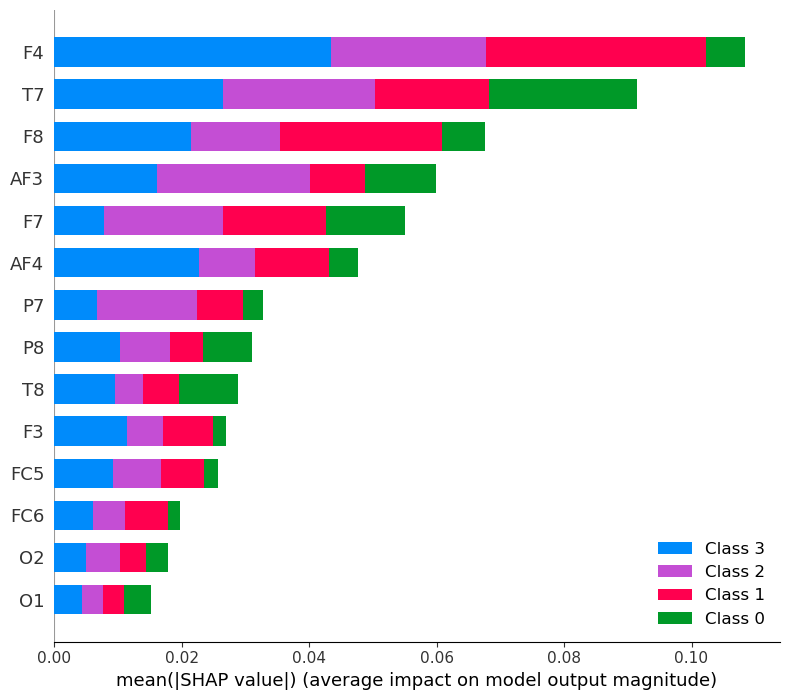

In [9]:
shap.summary_plot(shap_values, X_train_df)

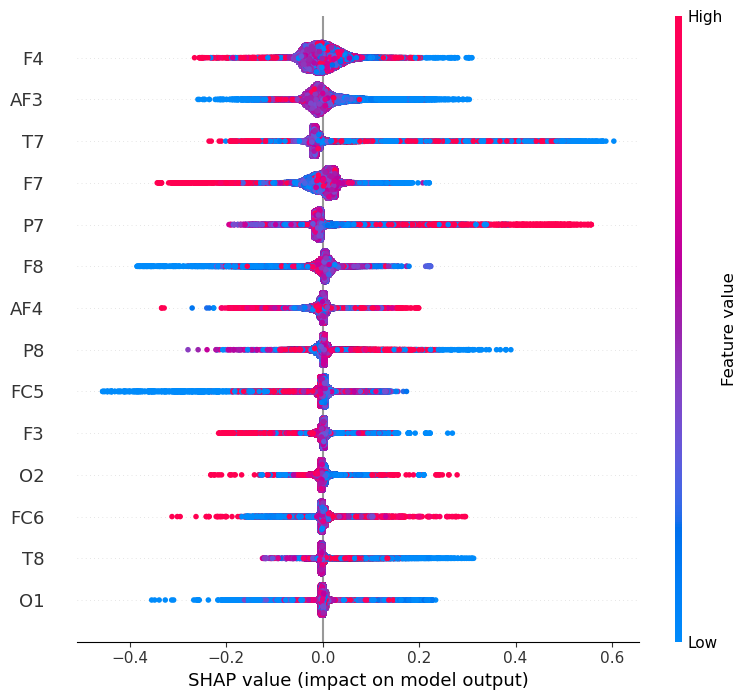

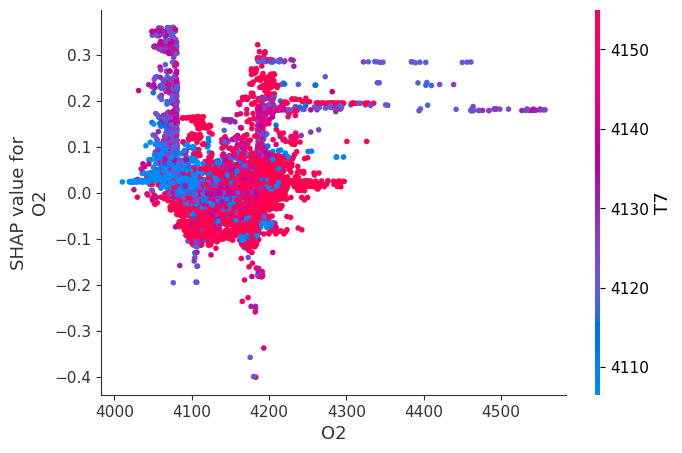

In [8]:
#SHAP値をプロット
shap.summary_plot(shap_values[2], X_train_df)
#各ｃｈの電圧値とSHAP値の線形グラフ
shap.dependence_plot("O2", shap_values[0], X_train_df)

In [12]:
num_classes = 4  # クラス数を設定
correlation_df = calculate_correlations(shap_values, X_train_df, column_names, num_classes).T
correlation_df

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
feature,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
correlation_0,0.381783,-0.360729,0.181389,0.032344,0.065678,-0.232106,-0.055646,0.071702,0.111254,-0.061746,0.098428,-0.084585,-0.10799,0.013257
correlation_1,-0.249702,0.142627,-0.421841,-0.129778,0.138847,-0.02289,-0.197267,0.444653,0.084286,0.043904,0.050568,0.653844,-0.135231,-0.089079
correlation_2,-0.251604,0.185388,-0.327273,-0.051758,-0.061801,0.062002,0.07331,-0.374307,0.165364,-0.125761,0.23791,0.077404,0.141236,0.03563
correlation_3,0.206549,-0.406126,0.003061,0.137617,-0.003735,-0.271652,-0.287977,0.283754,-0.214241,0.144479,0.190607,-0.618861,0.13852,0.200129


In [17]:
X100 = shap.utils.sample(X, 100)
explainer = shap.TreeExplainer(bst,X100)
shap_all = explainer(X[:100])
shap.plots.waterfall(shap_all[0])


KeyError: 0